In [3]:
import pickle
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

from IPython.display import HTML
import jax
import matplotlib
from ipywidgets import widgets
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray

grid_node_features = None
mesh_graph_structure = None
updated_latent_mesh_nodes = None
predictions = None
_mesh_nodes_lat = None
_mesh_nodes_lon = None


In [24]:
# import numpy as np

# # 加载 .npy 文件
# weights = np.load('../GraphCast-from-Ground-Zero/param/params_GraphCast - ERA5 1979-2017 - resolution 0.25 - pressure levels 37 - mesh 2to6 - precipitation input and output.npz', allow_pickle=True)

# for key in weights.files:
#     print(f"Key: {key}, Shape: {weights[key].shape}")
    
# weights["model_config:latent_size"]


In [5]:
with open('../graphcast-data/_mesh_nodes_lat.pkl', 'rb') as f:
    _mesh_nodes_lat = pickle.load(f)
with open('../graphcast-data/_mesh_nodes_lon.pkl', 'rb') as f:
    _mesh_nodes_lon = pickle.load(f)
with open('../graphcast-data/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open('../graphcast-data/forcings.pkl', 'rb') as f:
    forcings = pickle.load(f)
with open('../graphcast-data/prediction.pkl', 'rb') as f:
    predictions = pickle.load(f)
with open('../graphcast-data/grid_node_features.pkl', 'rb') as f:
    grid_node_features = pickle.load(f)
    
# channels 471 是怎么计算出来的？
# 37 levels * 2 time * 18 variables = 1332
# 466(每个变量的channels总和) + 5
# ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'day_progress_cos', 'day_progress_sin', 'geopotential', 'geopotential_at_surface', 'land_sea_mask', 'mean_sea_level_pressure', 'specific_humidity', 'temperature', 'toa_incident_solar_radiation', 'total_precipitation_6hr', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity', 'year_progress_cos', 'year_progress_sin']
# day_progress_cos, day_progress_sin, toa_incident_solar_radiation, year_progress_cos, year_progress_sin
grid_node_features.shape

# print(predictions)
# print(len(_mesh_nodes_lat))
# print((_mesh_nodes_lon))

(1038240, 1, 471)

In [43]:
# @title 载入绘图函数


def select(
    data: xarray.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xarray.Dataset:
  data = data[variable]
  if "batch" in data.dims:
    data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  if level is not None and "level" in data.coords:
    data = data.sel(level=level)
  return data

def scale(
    data: xarray.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  print(f"vmin: {vmin}, vmax: {vmax}")
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xarray.Dataset],
    fig_title: str,
    _mesh_nodes_lat: np.ndarray,
    _mesh_nodes_lon: np.ndarray,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)
  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()

  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    # print(plot_data.isel(time=0, missing_dims="ignore"))
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    
    
    lon = plot_data['lon'].values
    lat = plot_data['lat'].values
    

    # 添加经纬度坐标轴
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xticks(np.linspace(0, len(lon) - 1, 5))
    ax.set_yticks(np.linspace(0, len(lat) - 1, 5))
    ax.set_xticklabels(np.round(np.linspace(lon.min(), lon.max(), 5), 2), rotation=90)
    ax.set_yticklabels(np.round(np.linspace(lat.min(), lat.max(), 5), 2))
    

    # 提取 plot_data 中的经纬度坐标
    lon_vals = plot_data['lon'].values
    lat_vals = plot_data['lat'].values
    
    print(lon_vals)

    # 将 _mesh_nodes_lon 和 _mesh_nodes_lat 映射到图像索引
    lon_idx = np.interp(_mesh_nodes_lon, lon_vals, np.arange(len(lon_vals)))
    lat_idx = np.interp(_mesh_nodes_lat, lat_vals, np.arange(len(lat_vals)))

    print("_mesh_nodes_lon: ", _mesh_nodes_lon)
    print("lon_vals: ", lon_vals)
    print("lon_idx: ", lon_idx)
    # 在图像上绘制散点
    ax.scatter(lon_idx, lat_idx, color='black', s=5, label='Mesh Nodes', alpha=0.2)
    ax.scatter(lon_idx, lat_idx, color='black', s=5, label='Mesh Nodes', alpha=0.2)

    images.append(im)
    
    plt.show()




vmin: -1.8984375, vmax: 1.0859375
[0.0000e+00 2.5000e-01 5.0000e-01 ... 3.5925e+02 3.5950e+02 3.5975e+02]
_mesh_nodes_lon:  [ 60.      120.        0.      ... 142.95705 141.96313 141.79604]
lon_vals:  [0.0000e+00 2.5000e-01 5.0000e-01 ... 3.5925e+02 3.5950e+02 3.5975e+02]
lon_idx:  [240.         480.           0.         ... 571.82818604 567.85253906
 567.18414307]


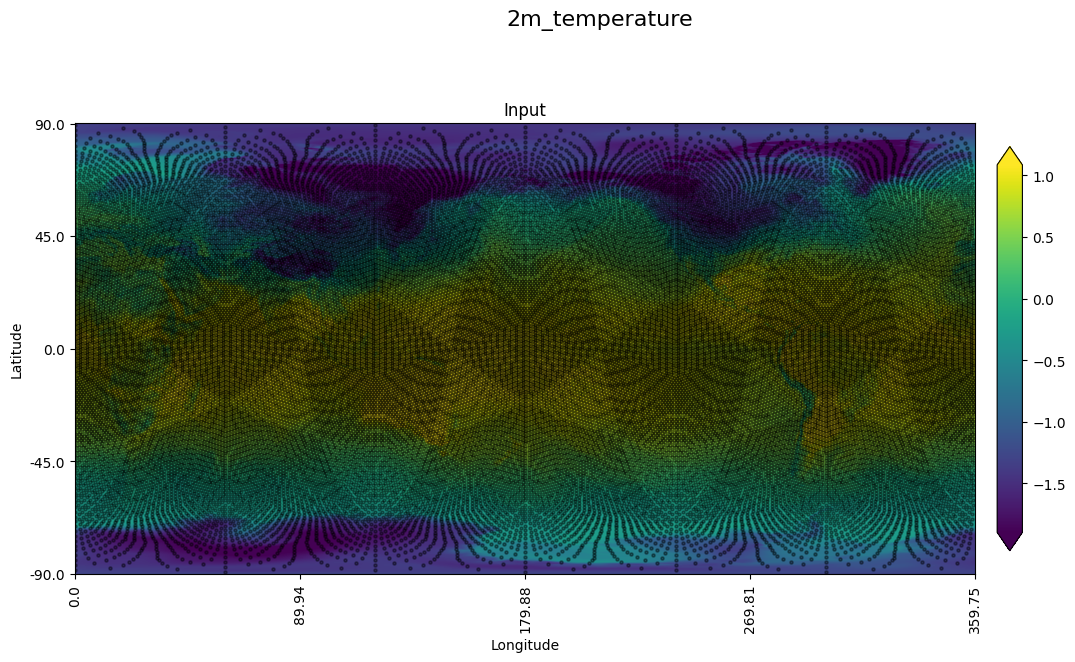

: 

In [44]:
data = {
    "Input": scale(inputs["2m_temperature"].isel(batch=0).astype('float32'), robust=True),
    # "Prediction": scale(predictions["2m_temperature"].isel(batch=0).astype('float32'), robust=True),
}

 
# def plot_data(
#     data: dict[str, xarray.Dataset],
#     fig_title: str,
#     _mesh_nodes_lat: np.ndarray,
#     _mesh_nodes_lon: np.ndarray,
#     plot_size: float = 5,
#     robust: bool = False,
#     cols: int = 4
#     ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:

#   first_data = next(iter(data.values()))[0]
#   max_steps = first_data.sizes.get("time", 1)
#   assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

#   cols = min(cols, len(data))
#   rows = math.ceil(len(data) / cols)
#   figure = plt.figure(figsize=(plot_size * 2 * cols,
#                                plot_size * rows))
#   figure.suptitle(fig_title, fontsize=16)
#   figure.subplots_adjust(wspace=0, hspace=0)
#   figure.tight_layout()

#   images = []
#   for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
#     print(plot_data.isel(time=0, missing_dims="ignore"))
#     ax = figure.add_subplot(rows, cols, i+1)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_title(title)
#     im = ax.imshow(
#         plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
#         origin="lower", cmap=cmap)
#     plt.colorbar(
#         mappable=im,
#         ax=ax,
#         orientation="vertical",
#         pad=0.02,
#         aspect=16,
#         shrink=0.75,
#         cmap=cmap,
#         extend=("both" if robust else "neither"))
    
    
#     lon = plot_data['lon'].values
#     lat = plot_data['lat'].values
    

#     # 添加经纬度坐标轴
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')
#     ax.set_xticks(np.linspace(0, len(lon) - 1, 5))
#     ax.set_yticks(np.linspace(0, len(lat) - 1, 5))
#     ax.set_xticklabels(np.round(np.linspace(lon.min(), lon.max(), 5), 2), rotation=90)
#     ax.set_yticklabels(np.round(np.linspace(lat.min(), lat.max(), 5), 2))
    
    
#     # 提取 plot_data 中的经纬度坐标
#     lon_vals = plot_data['lon'].values
#     lat_vals = plot_data['lat'].values
    
#     # 将 _mesh_nodes_lon 和 _mesh_nodes_lat 映射到图像索引
#     lon_idx = np.interp(_mesh_nodes_lon, lon_vals, np.arange(len(lon_vals)))
#     lat_idx = np.interp(_mesh_nodes_lat, lat_vals, np.arange(len(lat_vals)))

#     print(lon_idx, lat_idx)
#     # 在图像上绘制散点
#     # ax.scatter(lon_idx, lat_idx, color='black', s=5, label='Mesh Nodes', alpha=0.2)

#     images.append(im)
    
#     plt.show()





# scale(predictions["2m_temperature"].isel(batch=0).astype('float32'), robust=True)
# print(scale(predictions["2m_temperature"].isel(batch=0).astype('float32'), robust=True))
plot_data(data, "2m_temperature", _mesh_nodes_lat, _mesh_nodes_lon, 7, True)



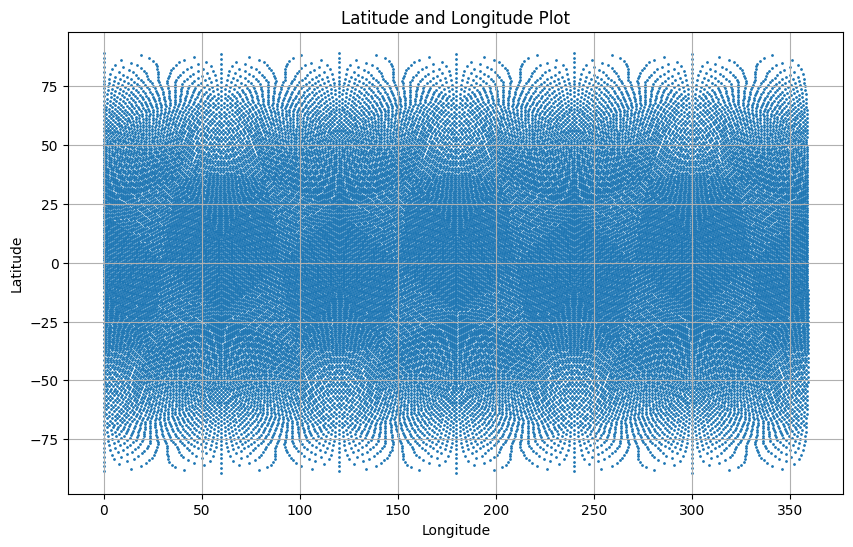

In [29]:
import matplotlib.pyplot as plt

# 创建一个新图
plt.figure(figsize=(10, 6))

# 绘制散点图，经纬度作为x和y坐标
plt.scatter(_mesh_nodes_lon, _mesh_nodes_lat, s=1)

# 设置图表标题和坐标轴标签
plt.title('Latitude and Longitude Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

(721, 1440)


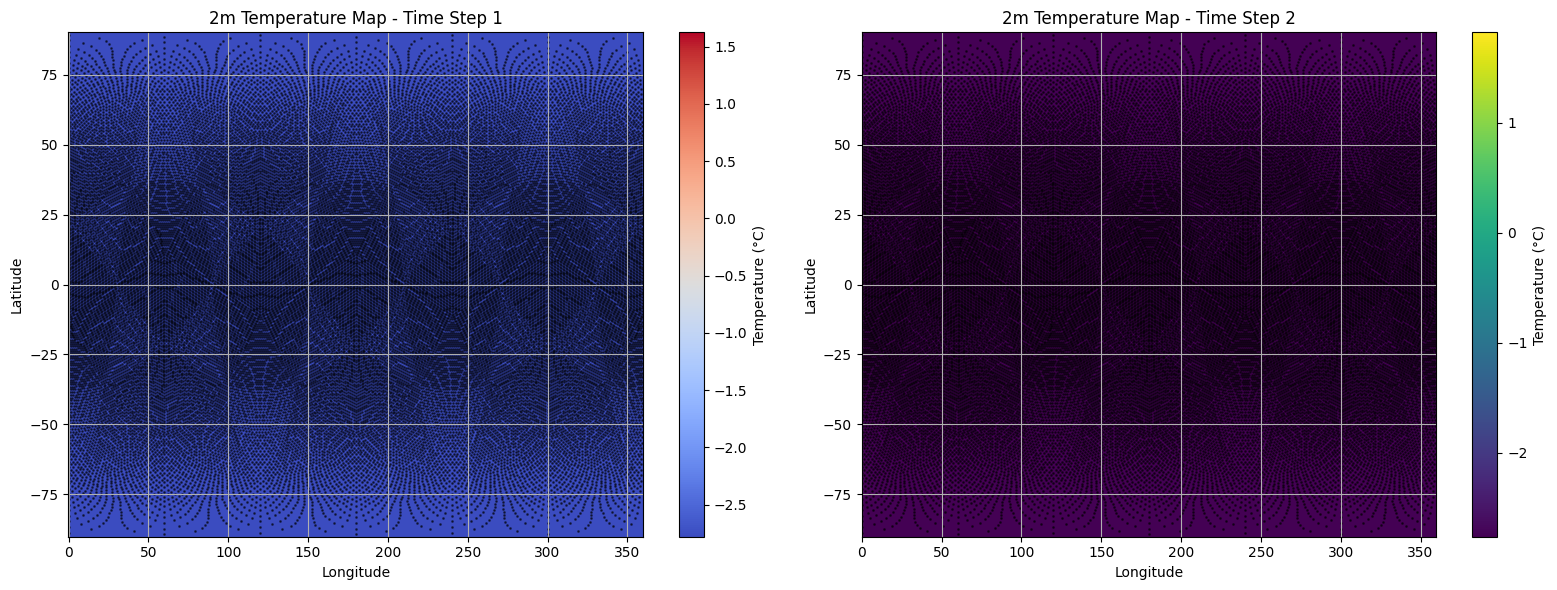

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# 假设数据形状为 (time, lat, lon)，比如 (2, 721, 1440)
# 获取经纬度和温度数据
latitudes = inputs['lat'].values  # 纬度 (721,)
longitudes = inputs['lon'].values  # 经度 (1440,)
temperature_data_time1 = inputs['2m_temperature'].values[0, 0]  # 第一个时间步的温度数据 (721, 1440)
temperature_data_time2 = inputs['2m_temperature'].values[0, 1]  # 第二个时间步的温度数据 (721, 1440)

print(temperature_data_time1.shape)

# 假设 _mesh_nodes_lon 和 _mesh_nodes_lat 是散点图的经纬度数据
# _mesh_nodes_lon = ...  # 填充你的经度数据
# _mesh_nodes_lat = ...  # 填充你的纬度数据

# 使用 np.meshgrid 生成经纬度网格
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# 创建图形，1 行 2 列的子图布局
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 绘制第一个时间步的温度图（第一个子图）
mesh1 = axes[0].pcolormesh(lon_grid, lat_grid, temperature_data_time1, cmap='coolwarm', shading='auto')
axes[0].set_title('2m Temperature Map - Time Step 1')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].grid(True)
fig.colorbar(mesh1, ax=axes[0], label='Temperature (°C)')

# 在第一个时间步的温度图上叠加散点图
axes[0].scatter(_mesh_nodes_lon, _mesh_nodes_lat, s=1, c='black', label='Mesh Nodes', alpha=0.5)

# 绘制第二个时间步的温度图（第二个子图）
mesh2 = axes[1].pcolormesh(lon_grid, lat_grid, temperature_data_time2, cmap='viridis', shading='auto')
axes[1].set_title('2m Temperature Map - Time Step 2')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].grid(True)
fig.colorbar(mesh2, ax=axes[1], label='Temperature (°C)')

# 在第二个时间步的温度图上叠加散点图
axes[1].scatter(_mesh_nodes_lon, _mesh_nodes_lat, s=1, c='black', label='Mesh Nodes', alpha=0.5)

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()



In [ ]:
# import matplotlib.pyplot as plt

# # 假设温度特征是第一个特征（索引0）
# temperature_feature = grid_node_features[:, 0, 0]

# # 绘制直方图
# plt.hist(temperature_feature, bins=50)
# plt.title('Temperature Feature Distribution')
# plt.xlabel('Temperature')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
with open('../graphcast-data/mesh_graph_structure.pkl', 'rb') as f:
    mesh_graph_structure = pickle.load(f)

print(mesh_graph_structure)    
# node_features是经纬度转球坐标，计算cos和sin得到  get_graph_spatial_features
# edge_features是球坐标计算距离得到
# mesh_graph_structure.nodes["mesh_nodes"]


In [ ]:
with open('../graphcast-data/updated_latent_mesh_nodes.pkl', 'rb') as f:
    updated_latent_mesh_nodes = pickle.load(f)

updated_latent_mesh_nodes.shape

In [ ]:
with open('../graphcast-data/prediction.pkl', 'rb') as f:
    predictions = pickle.load(f)

print(predictions)

In [37]:
plot_pred_variable = widgets.Dropdown(
    options=predictions.data_vars.keys(),
    value="2m_temperature",
    description="变量")
plot_pred_level = widgets.Dropdown(
    options=predictions.coords["level"].values,
    value=500,
    description="级别")
plot_pred_robust = widgets.Checkbox(value=True, description="鲁棒性")
plot_pred_max_steps = widgets.IntSlider(
    min=1,
    max=predictions.dims["time"],
    value=predictions.dims["time"],
    description="最大步")

widgets.VBox([
    plot_pred_variable,
    plot_pred_level,
    plot_pred_robust,
    plot_pred_max_steps,
    widgets.Label(value="运行下一个单元格，绘制预测结果。重新运行该单元格将清除您的选择。")
])


plot_data {'Predictions': (<xarray.DataArray '2m_temperature' (time: 1, lat: 721, lon: 1440)>
xarray_jax.JaxArrayWrapper(Array([[[-0.12695312, -0.12792969, -0.13085938, ..., -0.13183594,
         -0.13085938, -0.13085938],
        [-0.05444336, -0.05273438, -0.05419922, ..., -0.05761719,
         -0.05224609, -0.05371094],
        [-0.11376953, -0.11572266, -0.11572266, ..., -0.11376953,
         -0.11621094, -0.11621094],
        ...,
        [-0.26367188, -0.25390625, -0.2578125 , ..., -0.26367188,
         -0.25390625, -0.2578125 ],
        [-0.234375  , -0.23144531, -0.22753906, ..., -0.234375  ,
         -0.23242188, -0.23339844],
        [-0.2109375 , -0.21582031, -0.21582031, ..., -0.20898438,
         -0.21191406, -0.21484375]]], dtype=float32))
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) timedelta64[ns] 06:00:00, <matplotlib.colors.No

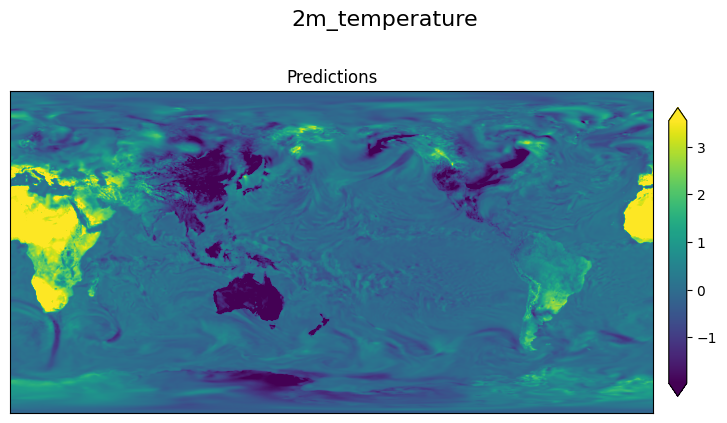

In [42]:
plot_size = 5
plot_max_steps = min(predictions.dims["time"], plot_pred_max_steps.value)

data = {
    # "Targets": scale(select(eval_targets, plot_pred_variable.value, plot_pred_level.value, plot_max_steps), robust=plot_pred_robust.value),
    "Predictions": scale(select(predictions, plot_pred_variable.value, plot_pred_level.value, plot_max_steps).astype("float32"), robust=plot_pred_robust.value),
    # "Diff": scale((select(eval_targets, plot_pred_variable.value, plot_pred_level.value, plot_max_steps) -
    #                     select(predictions, plot_pred_variable.value, plot_pred_level.value, plot_max_steps)),
    #                    robust=plot_pred_robust.value, center=0),
}
fig_title = plot_pred_variable.value
if "level" in predictions[plot_pred_variable.value].coords:
  fig_title += f" at {plot_pred_level.value} hPa"

plot_data(data, fig_title, plot_size, plot_pred_robust.value)